In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path="/content/gdrive/MyDrive/CPSC536R/Project"
os.chdir(path)
os.listdir(path)

Mounted at /content/gdrive


['Zeisel.h5ad',
 'sparse-vae-code',
 'pijuan_sala_atlas.h5ad',
 'cao_atlas.h5ad',
 'scvi-tools',
 'LDVAE_tests',
 'start.ipynb',
 'pi_10_150.csv',
 'pi_20_150.csv',
 'filtered_pi.h5ad',
 'filtered_pi_20_150.csv',
 'linear_decoder.ipynb',
 'pi_10000.h5ad']

# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
import os

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import numpy as np

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
os.kill(os.getpid(), 9)

In [ ]:
sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Initialization

Load data and select the top 1000 variable genes with seurat_v3 method

In [ ]:
from scvi.data.fields import AnnDataField
# save_path = "data"
# url = (
#     "https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true"
# )
# cells_dataset = sc.read(os.path.join(save_path, "pbmc_10k_protein_v3.h5ad"), backup_url=url)

save_path = "data/"
adata = sc.read(save_path + 'pijuan_sala_atlas.h5ad')

print(adata)

AnnData object with n_obs × n_vars = 139331 × 29452
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster'
    var: 'gene_name'


In [ ]:
# remove doublets
idx = adata.obs.query('not doublet').index
print("Remaining cells:", len(idx))
adata = adata[idx]

Remaining cells: 125775


In [ ]:
# cells with at least 1000 detected genes
# genes expressed in at least 10000 cells
sc.pp.filter_genes(adata, min_cells = 10000)
sc.pp.filter_cells(adata, min_genes = 1000)
print(adata.n_obs, adata.n_vars)

/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


125775 7961


In [ ]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 125775 × 7961
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'n_genes', 'n_counts'
    var: 'gene_name', 'n_cells'
    uns: 'log1p'

In [ ]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=1000, subset=True
)

/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
print(adata)
print(adata.X.shape)
## 139331 cells * 29452 genes => 125775 cells * 1000 genes

AnnData object with n_obs × n_vars = 125775 × 1000
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'n_genes', 'n_counts'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
(125775, 1000)


In [ ]:
adata.var_names = adata.var["gene_name"]
print(adata.var)

             gene_name  n_cells
gene_name                      
Sox17            Sox17    17304
Mrpl15          Mrpl15   120891
Lypla1          Lypla1    71164
Tcea1            Tcea1    81347
Atp6v1h        Atp6v1h    41683
...                ...      ...
mt-Nd6          mt-Nd6    10050
mt-Cytb        mt-Cytb   121766
Vamp7            Vamp7    66468
AC149090.1  AC149090.1    16881
DHRSX            DHRSX    38780

[7961 rows x 2 columns]


/usr/local/lib/python3.9/dist-packages/anndata/_core/anndata.py:879: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [ ]:
adata.var = adata.var.drop(['n_cells', 'highly_variable', 'means'], axis=1)
adata.obs = adata.obs.drop(columns = ['sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'n_genes', 'n_counts'])
# the names of the features(genes)
print(adata)

AnnData object with n_obs × n_vars = 125775 × 1000
    obs: 'barcode', 'sample', 'stage', 'cluster', 'cluster.sub', 'cluster.stage'
    var: 'gene_name', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


In [ ]:
import numpy as np

In [ ]:
def subsetFromAnnData(adata, n_cells):
    if n_cells > adata.n_obs:
        raise ValueError("The number of cells to extract is greater than the number of cells in the anndata object")

    cell_indices = np.random.choice(adata.n_obs, n_cells, replace=False)
    # Extract the selected cells and create a new anndata object
    return adata[cell_indices, :].copy()

In [ ]:
n_cells = 20000
cells_dataset = subsetFromAnnData(adata, n_cells)
cells_dataset

AnnData object with n_obs × n_vars = 20000 × 1000
    obs: 'barcode', 'sample', 'stage', 'cluster', 'cluster.sub', 'cluster.stage'
    var: 'gene_name', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [ ]:
cells_dataset.write('pi_20000.h5ad')

In [ ]:
adata.write('filtered_pi.h5ad')

## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [ ]:
# setup the anndata for scvi-tools
scvi.model.LinearSCVI.setup_anndata(cells_dataset)

/usr/local/lib/python3.9/dist-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [ ]:
# initialize LinearSCVI model
model = scvi.model.LinearSCVI(cells_dataset, n_latent=20)

In [ ]:
# train for 250 epochs, compute metrics every 10 epochs
model.train(max_epochs=150, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|██████████| 150/150 [04:20<00:00,  1.76s/it, loss=499, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [04:20<00:00,  1.74s/it, loss=499, v_num=1]


Inspecting the convergence

In [ ]:
train_elbo = model.history["elbo_train"]
test_elbo = model.history["elbo_validation"]

In [ ]:
train_elbo

,elbo_train
epoch,
0,3715.5625
1,839.210938
2,729.057739
3,665.61322
4,630.00592
...,...
145,516.986267
146,516.889221
147,516.83606


In [ ]:
test_elbo

,elbo_validation
epoch,
9,562.774048
19,542.673462
29,535.388245
39,531.067749
49,527.963806
59,526.232422
69,523.582764
79,523.299744
89,520.997681


<Axes: xlabel='epoch'>

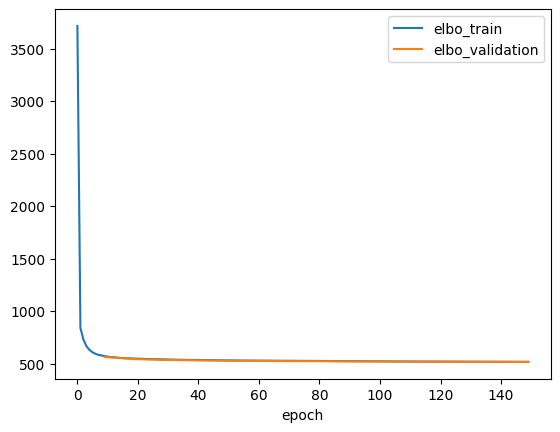

In [ ]:
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

## Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [ ]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    cells_dataset.obs[f"Z_{i}"] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

<ipython-input-46-6601b809a769>:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgd.legendHandles:
<ipython-input-46-6601b809a769>:26: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


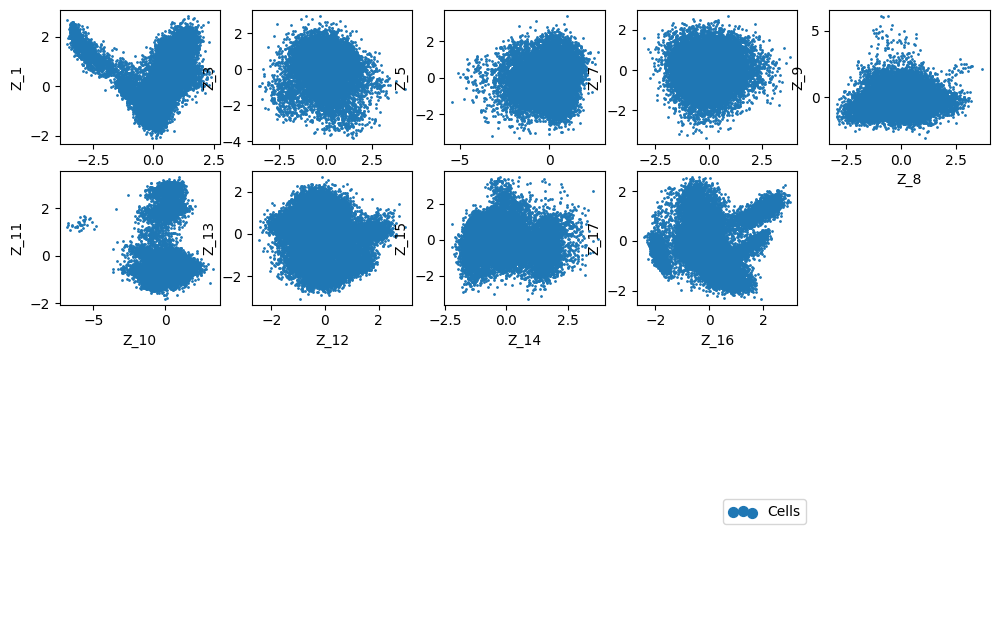

In [ ]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 18, 2):
    plt.subplot(4, 5, int(f / 2) + 1)

    plt.scatter(
        cells_dataset.obs[f"Z_{f}"], cells_dataset.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells"
    )

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(4, 3, 12)
plt.scatter(
    cells_dataset.obs[f"Z_{f}"], cells_dataset.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4
)
plt.scatter(cells_dataset.obs[f"Z_{f}"], cells_dataset.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

In [ ]:
z = pd.read_csv('../LDVAE_out/filtered_pi_20_150.csv', index_col=0)
# z = z_mean.detach().cpu().numpy()
_, variance_explained = Z_covariance(z.iloc[:, :-3])
idx = np.argsort(variance_explained)[::-1]
z = pd.DataFrame(z)
Z_df_ordered = pd.DataFrame(z.values[:, idx]).add_prefix('z')

variance_explained

array([0.07242691, 0.06552402, 0.06220234, 0.06024272, 0.031729  ,
       0.03477603, 0.0365755 , 0.04101226, 0.05491472, 0.05397352,
       0.0534246 , 0.04422924, 0.0447069 , 0.04591131, 0.04737185,
       0.05204226, 0.05086374, 0.0490484 , 0.04958063, 0.04944405])

In [ ]:
mutual_information_gap(Z_df_ordered, zs, zs)

0.04267301845280107

The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w\_(1, g) * z_1 + ... + w\_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w\_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [ ]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,Z_10,Z_11,Z_12,Z_13,Z_14,Z_15,Z_16,Z_17,Z_18,Z_19
gene_name,,,,,,,,,,,,,,,,,,,,
Sox17,0.257529,-0.196584,0.405810,-0.127419,-0.367566,0.291013,0.086531,-0.116973,0.352219,0.262369,-0.141569,0.039148,-0.359057,0.504799,0.205134,-0.325930,-0.889185,0.151747,-0.174830,-0.409299
Sgk3,-0.335104,-0.513713,-0.053638,-0.017054,-0.100380,0.223502,-0.139128,-0.005233,-0.299378,0.113866,0.138647,0.160125,-0.135796,0.071431,0.169406,0.036693,-0.217471,0.372670,0.023721,-0.211382
Rdh10,0.046573,0.294399,0.069526,0.084712,0.264470,0.222454,-0.139985,-0.296609,-0.119812,0.003441,0.176086,0.196620,-0.352989,0.160807,0.200818,0.030676,-0.104504,-0.172846,-0.163638,0.201154
Ptpn18,0.350303,-0.606607,0.004830,-0.177324,0.354804,0.229944,0.107648,-0.136291,-0.095860,-0.097880,0.076758,-0.176696,0.255159,0.118918,0.341264,-0.014522,-0.170055,0.191112,0.000595,-0.312865
Cfc1,0.064608,0.002497,-0.091178,0.038659,-0.065562,0.295914,0.249906,-0.331014,-0.436747,0.081735,0.371413,-0.341603,-0.293401,-0.549908,-0.178293,0.147299,-0.917388,0.414942,0.056254,0.111730


In [ ]:
loadings.to_csv('LDVAE_weights.csv', index=True)

For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [ ]:
print(
    "Top loadings by magnitude\n---------------------------------------------------------------------------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n---------------------------------------------------------------------------------------\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	Klf1, -1.1	Snca, -1.1	F10, -1.0	Acp5, -0.99	Cited4, -0.98
	...
	Tgfb2, 0.77	Ecscr, 0.79	Isl1, 0.8	Meis1, 0.82	Nrp1, 0.92
---------------------------------------------------------------------------------------

Z_1:	Psors1c2, -1.7	Eomes, -1.2	Nr0b1, -1.2	Mixl1, -1.2	Sh3gl3, -1.1
	...
	Hba-a2, 0.93	Hba-a1, 0.94	Hba-x, 0.94	Igfbp5, 0.96	Hbb-y, 1.2
---------------------------------------------------------------------------------------

Z_2:	Hoxa1, -0.35	Lrp2, -0.35	Stard8, -0.34	Eif2s3y, -0.33	Hotairm1, -0.28
	...
	Tcf15, 0.36	Sox17, 0.41	Hhex, 0.41	Fgf8, 0.43	Fgf17, 0.44
---------------------------------------------------------------------------------------

Z_3:	Cd59a, -0.62	Krt7, -0.61	Aplnr, -0.6	Ecscr, -0.6	Gypc, -0.59
	...
	Irx5, 0.48	Tfap2c, 0.48	Efna3, 0.56	Irx2, 0.62	Msx2, 0.62
---------------------------------------------------------------------------------------

It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data.

The `LinearSCVI` model further supports the same scVI functionality as the `SCVI` model, so all posterior methods work the same. Here we show how to use scanpy to visualize the latent space.

In [ ]:
cells_dataset.obsm["X_scVI"] = Z_hat
sc.pp.neighbors(cells_dataset, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(cells_dataset, min_dist=0.3)
sc.tl.leiden(cells_dataset, key_added="leiden_scVI", resolution=0.8)

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


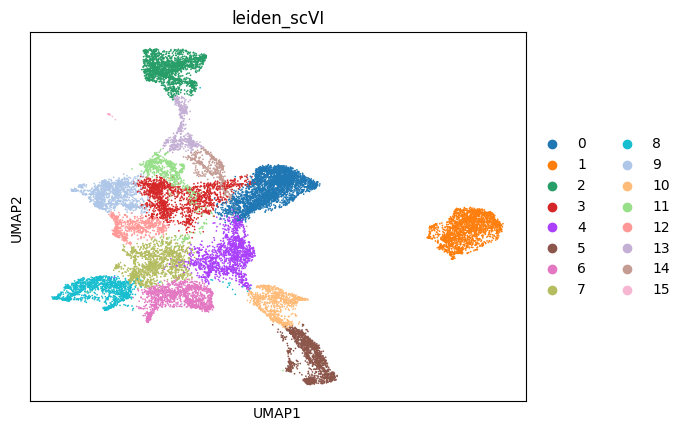

In [ ]:
sc.pl.umap(cells_dataset, color=["leiden_scVI"])

In [ ]:
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(cells_dataset, color=zs, ncols=3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
cells_dataset

AnnData object with n_obs × n_vars = 20000 × 1000
    obs: 'barcode', 'sample', 'stage', 'cluster', 'cluster.sub', 'cluster.stage', '_scvi_batch', '_scvi_labels', 'Z_0', 'Z_1', 'Z_2', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 'Z_8', 'Z_9', 'Z_10', 'Z_11', 'Z_12', 'Z_13', 'Z_14', 'Z_15', 'Z_16', 'Z_17', 'Z_18', 'Z_19', 'leiden_scVI'
    var: 'gene_name', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_scVI_colors'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [ ]:
cells_dataset_subset = cells_dataset.obs[zs + ['_scvi_batch', '_scvi_labels', 'leiden_scVI']]
cells_dataset_subset

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,...,Z_13,Z_14,Z_15,Z_16,Z_17,Z_18,Z_19,_scvi_batch,_scvi_labels,leiden_scVI
index,,,,,,,,,,,,,,,,,,,,,
cell_136090,1.120042,1.961398,0.683814,-0.775992,0.408032,-0.937759,-0.350280,-0.824651,-0.906709,0.607361,...,-0.336926,-0.261256,1.239370,-0.922965,-0.223132,1.141997,0.099122,0,0,6
cell_47724,0.183005,-0.845993,-0.684370,0.673210,0.790815,-1.275067,-0.918302,0.749704,1.044532,-0.337756,...,-1.485372,0.390433,-0.834178,-0.373308,1.086268,-0.629501,1.554267,0,0,4
cell_124071,-0.113481,-0.403055,-0.439868,0.054268,0.224737,0.426149,0.111075,1.810131,-0.487674,0.679373,...,0.441925,-1.411130,-1.087190,-0.082521,-0.437708,1.315768,0.957873,0,0,3
cell_40993,1.217616,1.350582,-0.070801,1.258172,1.466378,-0.223539,1.279429,0.184695,1.028411,-0.640650,...,0.924774,0.373227,0.552040,0.898408,-1.296543,1.163427,0.731048,0,0,9
cell_22099,-2.889389,1.469002,-0.311888,-0.502152,-0.288440,0.712994,0.317809,-0.592546,-0.049483,0.513628,...,0.128714,1.652567,-0.377759,1.191802,-0.471234,-0.198909,-0.422091,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_128674,0.743428,1.206678,-1.335751,-1.013100,0.535147,0.028954,0.687818,0.050003,-0.600457,-1.086865,...,-1.269092,-0.204260,0.758880,-1.282333,-0.169392,-0.529370,0.753822,0,0,8
cell_82341,0.004045,-0.482508,-0.056682,1.047657,-0.303308,-1.969282,1.116597,1.287782,1.203459,-0.200613,...,-1.123467,0.042715,0.059888,-0.523326,1.549604,-0.743294,0.151794,0,0,4
cell_45258,1.096171,-0.430611,-1.497230,0.411530,0.318452,-2.185605,-1.012326,-0.324778,0.431975,-0.190831,...,-1.384743,0.428026,-0.511043,0.116558,0.776788,-0.057473,1.618884,0,0,4


In [ ]:
# Save the subsetted AnnData object to a CSV file
cells_dataset_subset.to_csv('filtered_pi_20_150.csv')